# Location-scale regression

This tutorial implements a Bayesian location-scale regression model within the Liesel framework.
In contrast to the standard linear model with constant variance, the location-scale model allows for heteroscedasticity such that both the mean of the response variable as well as its variance depend on (possibly) different covariates.

This tutorial assumes a linear relationship between the expected value of the response and the regressors, whereas a logarithmic link is chosen for the standard deviation.
More specifically, we choose the model

$$
\begin{aligned}
y_i \sim \mathcal{N}_{} \left( \mathbf{x}_i^T \boldsymbol{\beta}, \exp \left( \mathbf{ z}_i^T \boldsymbol{\gamma} \right)^2 \right)
\end{aligned}
$$
in which the single observation are conditionally independent.

From the equation we see that *location* covariates are collected in the design matrix $\mathbf{X}$ and *scale* covariates are contained in the design matrix $\mathbf{ Z}$. Both matrices can, but generally do not have to, share common regressors.
We refer to $\boldsymbol{\beta}$ as location parameter and to $\boldsymbol{\gamma}$ as scale parameter.

In this notebook, both design matrices only contain one intercept and one regressor column.
However, the model design naturally generalizes to any (reasonable) number of covariates.


In [1]:
import liesel.goose as gs
import liesel.liesel as lsl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set_theme(style="whitegrid")

First lets generate the data according to the model

In [2]:
rng = np.random.default_rng(seed=13)
n = 500

true_beta = np.array([1.0, 3.0])
true_gamma = np.array([0.0, 0.5])

X = np.column_stack([np.ones(n), rng.uniform(low=0, high=5, size=n)])
Z = np.column_stack([np.ones(n), rng.normal(loc=2, scale=1, size=n)])

y = np.zeros(n)
for i in np.arange(n):
    mean = np.dot(X[i], true_beta)
    log_sd = np.dot(Z[i], true_gamma)
    y[i] = rng.normal(loc=mean, scale=np.exp(log_sd))

The simulated data displays a linear relationship between the response $\mathbf{y}$ and the covariate $\mathbf{x}$.
The slope of the estimated regression line is close to the true $\beta_1 = 3$.
The right plot shows the relationship between $\mathbf{y}$ and the scale covariate vector $\mathbf{z}$.
Larger values of $\mathbf{ z}$ lead to a larger variance of the response.

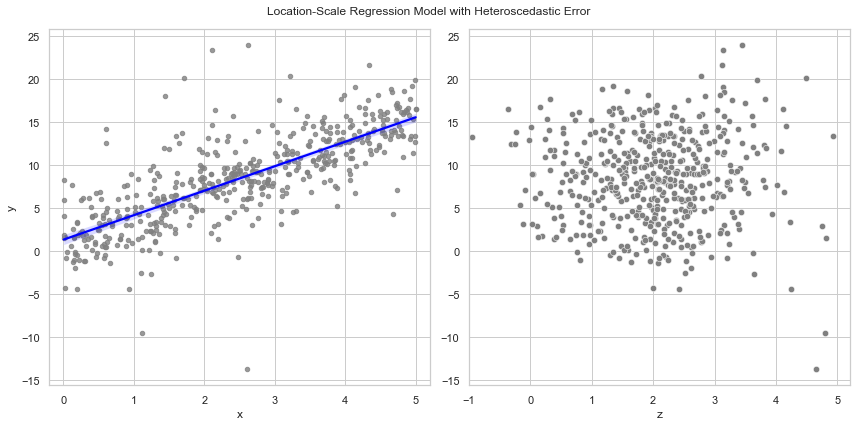

In [3]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
sns.regplot(
    x=X[:, 1],
    y=y,
    fit_reg=True,
    scatter_kws=dict(color="grey", s=20),
    line_kws=dict(color="blue"),
    ax=ax1,
).set(xlabel="x", ylabel="y", xlim=[-0.2, 5.2])

sns.scatterplot(
    x=Z[:, 1],
    y=y,
    color="grey",
    s=40,
    ax=ax2,
).set(xlabel="z", xlim=[-1, 5.2])

fig.suptitle("Location-Scale Regression Model with Heteroscedastic Error")
fig.tight_layout()
plt.show()

Since positivity of the variance is ensured by the exponential function, the linear part $\mathbf{z}_i^T \boldsymbol{\gamma}$ is not restricted to the positive real line.
Hence, setting a normal prior distribution for $\gamma$ is feasible, leading to an almost symmetric specification of the location and scale parts of the model.
The nodes `n_beta` and `n_gamma` are initialized with values far away from zero to support a stable sampling process:

In [4]:
n_beta_loc = lsl.Hyperparameter(value=0.0, name="beta_loc")
n_beta_scale = lsl.Hyperparameter(value=10.0, name="beta_scale")
dist_beta = lsl.NodeDistribution(
    distribution="Normal", loc=n_beta_loc, scale=n_beta_scale
)
n_beta = lsl.RegressionCoef(
    value=np.array([10.0, 10.0]), distribution=dist_beta, name="beta"
)

n_gamma_loc = lsl.Hyperparameter(value=0.0, name="gamma_loc")
n_gamma_scale = lsl.Hyperparameter(value=3.0, name="gamma_scale")
dist_gamma = lsl.NodeDistribution(
    distribution="Normal", loc=n_gamma_loc, scale=n_gamma_scale
)
n_gamma = lsl.RegressionCoef(
    value=np.array([5.0, 5.0]), distribution=dist_gamma, name="gamma"
)

The additional complexity of the location-scale model compared to the standard linear model is handled in the next step.
Since `n_gamma` takes values on the whole real line, but the response node `n_y` expects a positive scale input, we transform the `Linear Smooth` node with a `Bijector` object, which is placed in between the linear predictor `n_scale_linear` and the response node `n_y`:

In [5]:
n_X = lsl.DesignMatrix(value=X, name="X")
n_Z = lsl.DesignMatrix(value=Z, name="Z")

n_y_hat = lsl.Smooth(n_X, n_beta, name="y_hat")
n_scale_linear = lsl.Smooth(n_Z, n_gamma, name="scale_pred")
n_scale = lsl.Bijector(bijector="Exp", input=n_scale_linear, name="scale")

dist_y = lsl.NodeDistribution(distribution="Normal", loc=n_y_hat, scale=n_scale)
n_y = lsl.Response(value=y, distribution=dist_y, name="y")

We can now combine the nodes in a model and visulize it

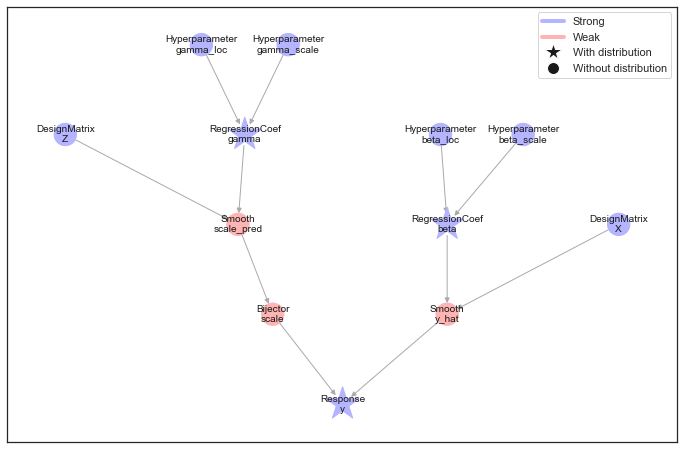

In [6]:
sns.set_theme(style="white")

mb = lsl.ModelBuilder()
mb.add_nodes(n_y)
loc_scale_model = mb.build()
lsl.plot_model(model=loc_scale_model, width=12, height=8)

We choose the No U-Turn sampler for generating posterior samples.
Therefore the location and scale parameters can be drawn by separate NUTS kernels, or, if all remaining inputs to the kernel coincide, by one common kernel.
The latter option might lead to better estimation results but lacks the flexibility to e.g. choose different step sizes during the sampling process.

However, we will just fuse everything into one kernel do not use any specific arguments and hope that the default warmup scheme (similar to the warmup used in STAN) will do the trick.

In [7]:
builder = gs.EngineBuilder(seed=3, num_chains=4)

# connects the engine with the model
builder.set_model(lsl.GooseModel(loc_scale_model))

# add the kernel
builder.add_kernel(gs.NUTSKernel(["beta", "gamma"]))

# set number of iterations in warmup and posterior
builder.set_duration(warmup_duration=1500, posterior_duration=1000, term_duration=500)

# we use the same initial values for all chains
builder.set_initial_values(loc_scale_model.state)

# create the engine
engine = builder.build()

# generate samples
engine.sample_all_epochs()

INFO - Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 
INFO - Unable to initialize backend 'gpu': NOT_FOUND: Could not find registered platform with name: "cuda". Available platform names are: Interpreter Host
INFO - Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.
WARNING - No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
INFO - Starting epoch: FAST_ADAPTATION, 75 transitions, 25 jitted together
WARNING - Errors per chain for kernel_00: 7, 7, 3, 8 / 75 transitions
INFO - Finished epoch
INFO - Starting epoch: SLOW_ADAPTATION, 25 transitions, 25 jitted together
WARNING - Errors per chain for kernel_00: 1, 2, 2, 1 / 25 transitions
INFO - Finished epoch
INFO - Starting epoch: SLOW_ADAPTATION, 50 transitions, 25 jitted together
WARNING - Errors per chain for kernel_00: 2, 1, 2, 5 / 50 transitions
INFO - Finished epoch
INFO - Starting epoch: SLOW_ADAPTATION, 

Now that we have 1000 posterior samples per chain, we can check the results. Starting with the trace plots just using one chain.

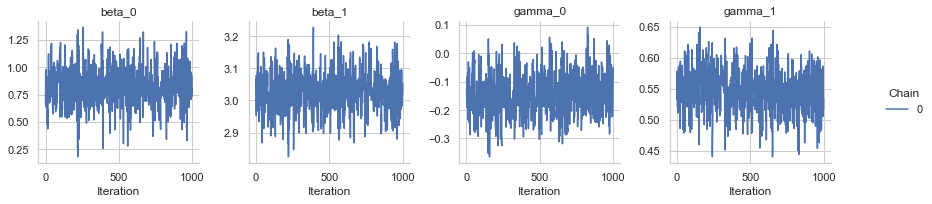

In [8]:
results = engine.get_results()
g = gs.plot_trace(results, chain_indices=0, ncol=4)

Looks decent although we can see some correlation in the tracplots especially for $\beta$. Let's check at the combined summary:

In [9]:
gs.summary(results, per_chain=False)

,param_index,num_samples,num_effective,mean,sd,rhat,q_5,q_50,q_95,hdi_90_low,hdi_90_high
beta,0,4000,1485.360,0.830,0.174,1.002,0.548,0.825,1.119,0.539,1.106
beta,1,4000,1464.465,3.024,0.059,1.002,2.927,3.024,3.122,2.928,3.123
gamma,0,4000,1713.882,-0.139,0.070,1.005,-0.258,-0.140,-0.023,-0.260,-0.026
gamma,1,4000,1808.452,0.542,0.032,1.005,0.490,0.542,0.596,0.489,0.595


Maybe a longer warm-up would give us better samples.

In [10]:
builder = gs.EngineBuilder(seed=3, num_chains=4)

# connects the engine with the model
builder.set_model(lsl.GooseModel(loc_scale_model))

# add the kernel
builder.add_kernel(gs.NUTSKernel(["beta", "gamma"]))

# set number of iterations in warmup and posterior
builder.set_duration(warmup_duration=4000, posterior_duration=1000, term_duration=1000)

# we use the same initial values for all chains
builder.set_initial_values(loc_scale_model.state)

# create the engine
engine = builder.build()

# generate samples
engine.sample_all_epochs()

INFO - Starting epoch: FAST_ADAPTATION, 75 transitions, 25 jitted together
WARNING - Errors per chain for kernel_00: 7, 7, 3, 8 / 75 transitions
INFO - Finished epoch
INFO - Starting epoch: SLOW_ADAPTATION, 25 transitions, 25 jitted together
WARNING - Errors per chain for kernel_00: 1, 2, 2, 1 / 25 transitions
INFO - Finished epoch
INFO - Starting epoch: SLOW_ADAPTATION, 50 transitions, 25 jitted together
WARNING - Errors per chain for kernel_00: 2, 1, 2, 5 / 50 transitions
INFO - Finished epoch
INFO - Starting epoch: SLOW_ADAPTATION, 100 transitions, 25 jitted together
WARNING - Errors per chain for kernel_00: 2, 3, 4, 2 / 100 transitions
INFO - Finished epoch
INFO - Starting epoch: SLOW_ADAPTATION, 200 transitions, 25 jitted together
WARNING - Errors per chain for kernel_00: 4, 2, 1, 2 / 200 transitions
INFO - Finished epoch
INFO - Starting epoch: SLOW_ADAPTATION, 400 transitions, 25 jitted together
WARNING - Errors per chain for kernel_00: 4, 5, 7, 7 / 400 transitions
INFO - Finishe

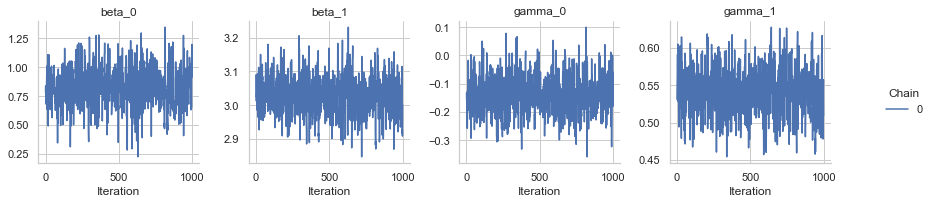

In [11]:
results = engine.get_results()
g = gs.plot_trace(results, chain_indices=0, ncol=4)

In [12]:
gs.summary(results, per_chain=False)

,param_index,num_samples,num_effective,mean,sd,rhat,q_5,q_50,q_95,hdi_90_low,hdi_90_high
beta,0,4000,2091.877,0.831,0.172,1.002,0.559,0.832,1.120,0.552,1.111
beta,1,4000,2087.797,3.024,0.058,1.002,2.926,3.025,3.117,2.924,3.114
gamma,0,4000,1977.613,-0.137,0.073,1.002,-0.253,-0.138,-0.015,-0.253,-0.015
gamma,1,4000,2084.114,0.542,0.032,1.002,0.487,0.542,0.594,0.489,0.596


Not really 😭